In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from pycocotools.coco import COCO
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 20.0)

In [18]:
def default_img_fldr(video_path):
    return video_path.split('/')[-1].split('.')[0]

# may not be used 
def gen_all_frames_from_video(video_path, output_folder=None):
    if not output_folder:
        output_folder = default_img_fldr(video_path)

    os.system(f'ffmpeg -i {video_path} {output_folder}/%d.jpeg')


def frame_num(output_folder=None, ext='.jpeg'):
    if not output_folder:
        output_folder = default_img_fldr(video_path)
    os.listdir('imgs')

def single_frame_by_time(video_path, seconds, output_name):
    # ffmpeg -i input_file.mp4 -ss 01:23:45.. -vframes 1 output.jpg
    os.system(f'ffmpeg -i {video_path} {output_name}')
    
def get_vid_meta(filename):
    video = cv2.VideoCapture(filename)
    frame_count = video.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = video.get(cv2.CAP_PROP_FPS) 
#     print(fps)
    duration = frame_count / fps
    return fps, duration, frame_count

def sec2frame(seconds, fps):
    return round(seconds*fps)

In [19]:
ls shark_human_annotations/

ls: shark_human_annotations/: No such file or directory


In [20]:
name = '20210403_SharkAndBodyboarders'


video = f'data/{name}.mp4'
get_vid_meta(video)

(29.97003031220243, 29.195833, 875.0)

In [22]:
folder = f'shark_frames/{name}'
imgs = sorted(os.listdir(folder))
paths = [f'{folder}/{f}' for f in imgs]
paths[0], paths[-1], len(paths)

('shark_frames/20210403_SharkAndBodyboarders/20210403_SharkAndBodyboarders-0001.jpg',
 'shark_frames/20210403_SharkAndBodyboarders/20210403_SharkAndBodyboarders-0875.jpg',
 875)

In [91]:
annot_folder = 'shark_human_annotations'
annot_file = f'{annot_folder}/{name}.json'
with open(annot_file) as f: 
    contents = json.load(f)

In [92]:
annot = contents['metadata']
attr = contents['attribute']

blocks, obj_seg = [], []

for d in annot.values():
    if len(d['z']) == 1:
        obj_seg.append(d)
    else:
        blocks.append(d)

In [93]:
name2i_attr = {d['aname']: i for i, d in attr.items()}
object_present = name2i_attr['object_present']
object_id = name2i_attr['object_id']
object_present

'1'

In [172]:
# coco-like !!! but not everything is included....
coco_dict = {
        'images': [
#             {"id": 1, "file_name": "<filename0>.<ext>"} 
        ], 
        'annotations': [
#             {"id": 1, "image_id": 1, "category_id": 2,
#             "bbox": [260, 177, 231, 199], 'keypoint': None
#             "area": 45969, "iscrowd": False
#             },
        ], 
        "categories": [
#            {"id": 2, "name": "cat", "supercategory": "animal",}
        ]
}

In [173]:
# just gonna use object present & object id 
cat2id = {}
fps, duration, frame_ct = get_vid_meta(video)
id_count = 0
for i, obj in enumerate(obj_seg):
    av = obj['av']
    dropped=True
    printf=False
    # ==2 checks for rectangle 
    if av.get(object_present, None) and obj['xy'][0] == 2:
        dropped=False
        # get category & id 
        cat = av[object_present].strip()
        c_id = av.get(object_id, '0').strip()
        # adding to categories.....if needed
        if (cat, c_id) not in cat2id:
#             print(cat, c_id)
#             print(obj)
#             printf =True 
            cat2id[(cat, c_id)] = id_count
            id_count +=1
        
        coco_dict['annotations'].append({
            # we need this for some reason....
            'id': i,
            'keypoints': None,
            'category_id': cat2id[(cat, c_id)],
            "image_id": sec2frame(obj['z'][0], fps), 
            'bbox': obj['xy'][1:],
            'area': obj['xy'][-1]*obj['xy'][-2]

        })
#         if printf:
#             print(coco_dict['annotations'][-1])
    if dropped:
        print('dropped:', obj)

In [174]:
coco_dict['images'] = [{'id':i, 'file_name':fn} for i, fn in enumerate(paths)]

In [175]:
coco_dict['categories'] = [{'id': i, 'name': f'{cat}_{im}', 'supercategory':cat} for (cat, im), i in cat2id.items()]
coco_dict['categories']

[{'id': 0, 'name': 'shark_1', 'supercategory': 'shark'},
 {'id': 1, 'name': 'shark_0', 'supercategory': 'shark'},
 {'id': 2, 'name': 'human_0', 'supercategory': 'human'},
 {'id': 3, 'name': 'shark_q', 'supercategory': 'shark'},
 {'id': 4, 'name': 'human_1', 'supercategory': 'human'}]

In [176]:
# coco_dict

In [177]:
coco_dict['annotations'][0]

{'id': 0,
 'keypoints': None,
 'category_id': 0,
 'image_id': 0,
 'bbox': [1892.622, 623.883, 47.185, 73.398],
 'area': 3463.28463}

In [178]:
annFile = 'test.json'
with open(annFile, 'w') as f:
    json.dump(coco_dict, f)

In [179]:
from pycocotools.coco import COCO

In [180]:

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [193]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

# nms = set([cat['supercategory'] for cat in cats])
# print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
shark_1 shark_0 human_0 shark_q human_1



In [194]:
nms

['shark_1', 'shark_0', 'human_0', 'shark_q', 'human_1']

In [195]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=nms);
# catIds
# imgIds = coco.getImgIds(catIds=catIds);
# imgIds
imgIds = coco.getImgIds(imgIds = [0])
# imgIds
img = coco.loadImgs(imgIds[0])[0]
# img

In [196]:
img

{'id': 0,
 'file_name': 'shark_frames/2020731_JWSSeaLIonSUP/2020731_JWSSeaLIonSUP-0001.jpg'}

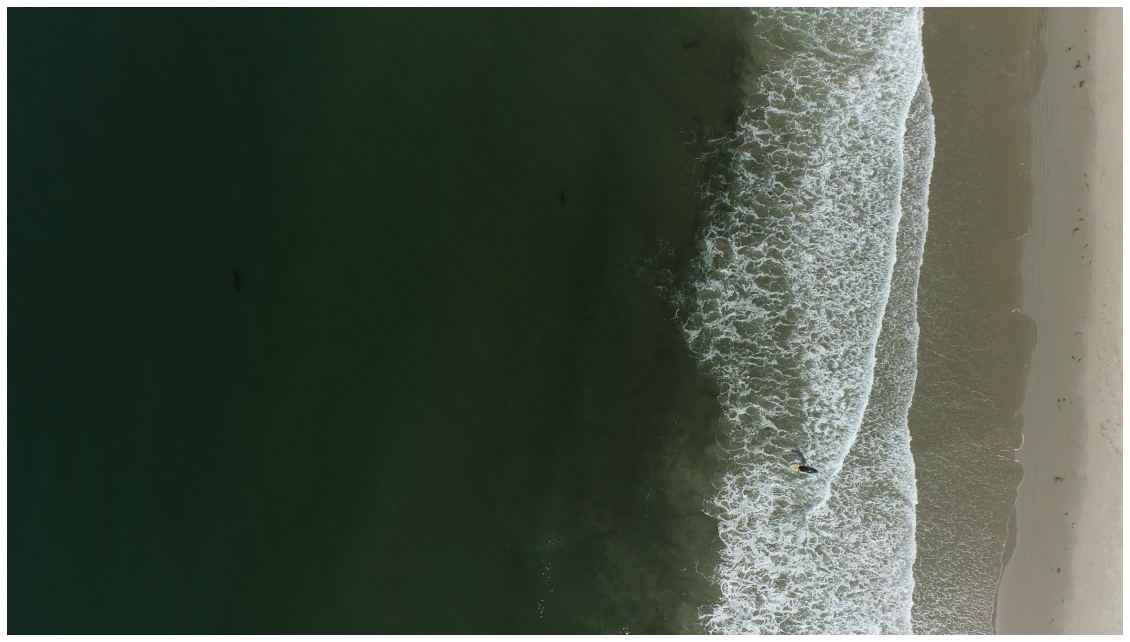

In [197]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

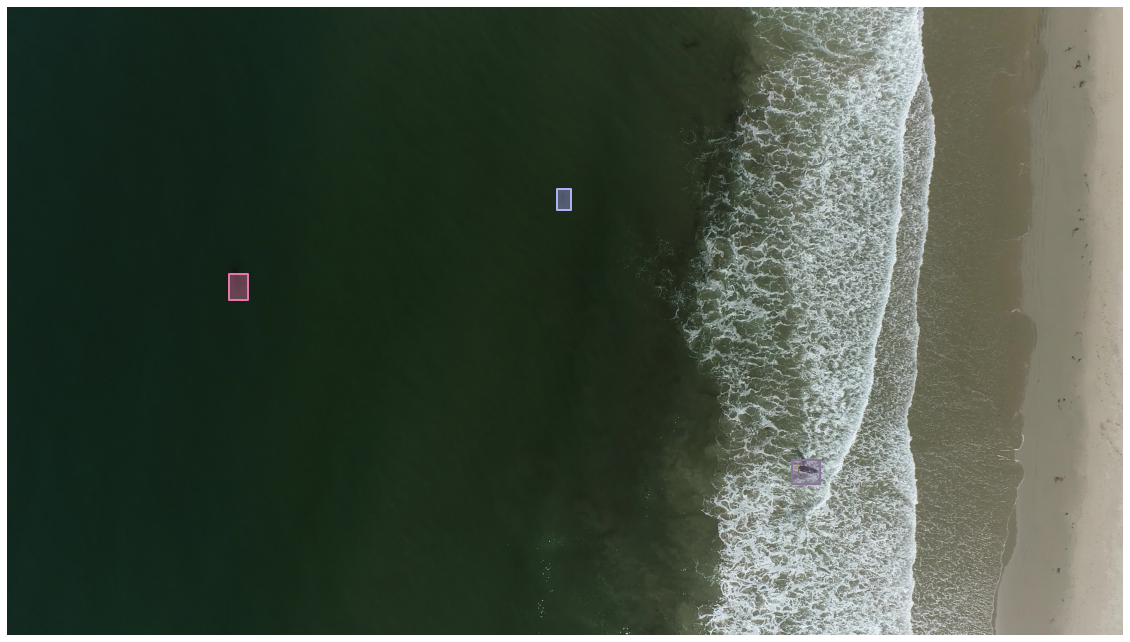

In [198]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
# coco.showAnns(anns, draw_bbox=True)
# annIds
anns